In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time 
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

4998
4995
4993
4990
4999
4996
4992
4991
4997
4994


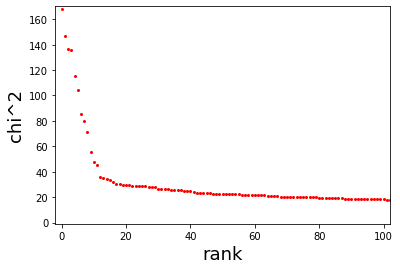

In [2]:
N = 500
M = 5000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
for i in range(10):
    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, stats, marker="o", markersize=2, color = "red", linestyle = "None")
#plt.axhline(33.6, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2", fontsize = 18)
fig.savefig("stats_large.png")
fig.savefig("fig/stats-large.eps")

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [12]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [13]:
def RankError(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    RE = np.zeros(4)
    for j in range(3):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 3
        
    return RE

[[2.97766667e+03 6.00000000e+00 2.47433333e+03 2.28666667e+03]
 [2.86366667e+03 4.00000000e+00 1.79766667e+03 2.48133333e+03]
 [3.60533333e+03 1.66666667e+00 9.03333333e+02 3.29600000e+03]
 [3.58000000e+03 3.66666667e+00 0.00000000e+00 3.33333333e-01]
 [3.08400000e+03 5.33333333e+00 3.33333333e-01 0.00000000e+00]
 [2.24766667e+03 5.33333333e+00 1.00000000e+00 0.00000000e+00]]
[[2.16133333e+03 3.66666667e+00 2.87766667e+03 1.62366667e+03]
 [3.62100000e+03 4.00000000e+00 2.45900000e+03 2.38900000e+03]
 [2.25233333e+03 7.33333333e+00 1.88133333e+03 7.56333333e+02]
 [1.47966667e+03 6.00000000e+00 3.33333333e-01 6.66666667e-01]
 [2.36633333e+03 5.33333333e+00 3.33333333e-01 0.00000000e+00]
 [3.45966667e+03 1.00000000e+00 6.66666667e-01 0.00000000e+00]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[3.30800000e+03 2.33333333e+00 3.93833333e+03 3.02166667e+03]
 [3.18366667e+03 3.66666667e+00 1.84166667e+03 3.11366667e+03]
 [2.95966667e+03 6.33333333e+00 2.14666667e+03 2.75833333e+03]
 [1.65033333e+03 4.00000000e+00 2.00000000e+00 1.00000000e+00]
 [1.96766667e+03 4.33333333e+00 0.00000000e+00 1.00000000e+00]
 [1.75666667e+03 2.66666667e+00 3.33333333e-01 0.00000000e+00]]


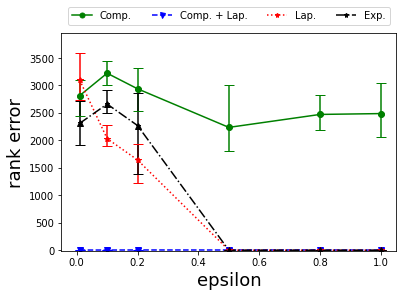

In [14]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(3):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 3

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(3)

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=1.png")
fig.savefig("fig/RE_large_K=1.eps")

[[2.46855556e+03 3.22222222e+00 2.17755556e+03 2.86200000e+03]
 [2.48344444e+03 4.44444444e+00 2.31377778e+03 2.55833333e+03]
 [2.51944444e+03 1.75111111e+02 2.17755556e+03 2.02600000e+03]
 [2.68555556e+03 4.22222222e+00 2.37811111e+03 2.81977778e+03]
 [3.85222222e+03 5.22222222e+00 2.94377778e+03 1.75455556e+03]
 [1.92711111e+03 2.55555556e+00 1.39400000e+03 1.20966667e+03]]
[[2.85244444e+03 3.88888889e+00 3.02811111e+03 3.01922222e+03]
 [2.92555556e+03 7.90444444e+02 1.73322222e+03 2.00844444e+03]
 [2.96833333e+03 3.11111111e+00 3.14366667e+03 2.51277778e+03]
 [3.14444444e+03 3.88888889e+00 3.25311111e+03 2.03733333e+03]
 [2.54177778e+03 3.77777778e+00 2.05255556e+03 1.89211111e+03]
 [3.84544444e+03 4.77777778e+00 3.17422222e+03 1.15977778e+03]]
[[3.47288889e+03 2.77777778e+00 1.88722222e+03 2.06033333e+03]
 [3.74177778e+03 4.00000000e+00 2.86911111e+03 2.05988889e+03]
 [1.52566667e+03 2.58333333e+02 3.50311111e+03 2.10522222e+03]
 [3.43511111e+03 4.33333333e+00 2.40955556e+03 2.2521

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


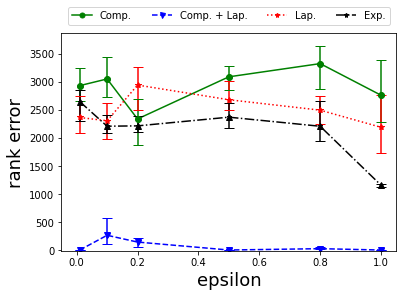

In [15]:
eta = 10
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(3):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 3

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(3)

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=3.png")
fig.savefig("fig/RE_large_K=3.eps")

[[2.97726667e+03 2.93333333e+00 2.42446667e+03 2.43846667e+03]
 [3.35206667e+03 3.46666667e+00 1.57320000e+03 2.11886667e+03]
 [3.20386667e+03 2.47466667e+02 3.05060000e+03 2.68566667e+03]
 [2.45066667e+03 1.14840000e+03 2.73526667e+03 2.31886667e+03]
 [3.56453333e+03 9.98333333e+02 2.63993333e+03 2.60173333e+03]
 [1.82373333e+03 4.22666667e+01 1.86473333e+03 2.06086667e+03]]
[[2946.66666667  692.8        2479.06666667 2053.26666667]
 [2902.33333333  235.8        2010.73333333 2131.73333333]
 [2732.26666667    3.53333333 2763.93333333 2390.33333333]
 [2406.33333333  493.26666667 2575.8        2549.33333333]
 [2854.73333333    3.26666667 2072.53333333 2128.53333333]
 [2912.          646.93333333 2403.46666667 1898.46666667]]
[[2951.66666667    3.86666667 2749.66666667 1950.6       ]
 [3376.86666667  571.         2140.06666667 2603.93333333]
 [2743.06666667    5.8        2433.26666667 3189.13333333]
 [3505.06666667  514.2        2074.13333333 2395.93333333]
 [3169.46666667  270.6        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


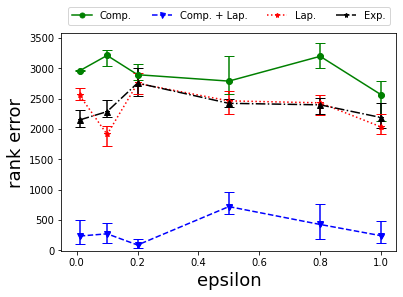

In [16]:
eta = 10
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(3):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 3

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(3)

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=5.png")
fig.savefig("fig/RE_large_K=5.eps")

[[3088.53333333 1683.33333333 2789.56666667 2714.6       ]
 [3146.5        1705.43333333 2103.         2327.23333333]
 [2975.93333333  923.6        2174.43333333 2713.26666667]
 [2969.03333333 1028.66666667 2391.7        2221.96666667]
 [3362.63333333 1393.83333333 2152.56666667 2155.6       ]
 [3170.03333333  657.63333333 2427.16666667 2623.43333333]]
[[3269.63333333 1543.1        2231.46666667 2856.26666667]
 [2800.56666667 1478.8        2139.96666667 2537.3       ]
 [3151.7        1355.53333333 2475.3        2571.73333333]
 [2935.16666667  683.83333333 2601.26666667 2335.33333333]
 [2992.         1548.66666667 1943.2        2430.3       ]
 [2401.1        1246.83333333 2588.46666667 2537.36666667]]
[[2931.56666667 1213.7        2511.5        2787.13333333]
 [2997.4         874.7        2853.1        2305.03333333]
 [2500.16666667 1395.93333333 2479.76666667 2647.8       ]
 [3050.4         740.73333333 2471.13333333 2177.56666667]
 [3489.53333333 1747.06666667 2469.63333333 2112.1    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


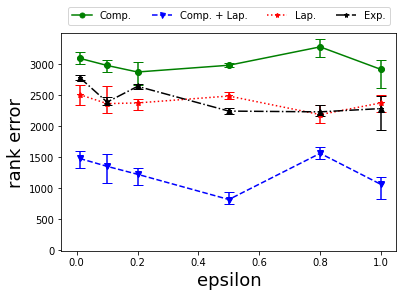

In [17]:
eta = 10
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(3):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 3

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]
y_err /= np.sqrt(3)

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=10.png")
fig.savefig("fig/RE_large_K=10.eps")